In [2]:
# 학습 정확도 및 손실 시각화 함수
import matplotlib.pyplot as plt

def plot_training_history(history):

    plt.figure(figsize=(14, 6))

    # 정확도
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')

    # 손실
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')

    # 레이아웃 자동 조정 및 출력
    plt.tight_layout()
    plt.show()
    print()

# 예측 결과 시각화 함수
import numpy as np

def plot_predictions(x_test, y_test, predictions, class_names, num_images=10):

    plt.figure(figsize=(25, 30))

    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(x_test[i])
        plt.xticks([])
        plt.yticks([])
        true_label = np.argmax(y_test[i])
        predicted_label = np.argmax(predictions[i])
        plt.xlabel(f"True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}", fontsize=12)

        # 예측 확률 출력
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.barh(class_names, predictions[i], color='blue', height=0.2)
        plt.xlim([0, 1])
        plt.yticks(np.arange(len(class_names)), class_names, fontsize=12)
        plt.xlabel('Probability', fontsize=12)

    plt.tight_layout()
    plt.show()
    print()

### Tiny ImageNet 데이터셋 로드

In [3]:
import zipfile
import urllib.request
import os

# Tiny ImageNet 데이터 다운로드 및 압축 해제
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
output_path = 'tiny-imagenet-200.zip'
urllib.request.urlretrieve(url, output_path)

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('tiny-imagenet-200')

# Tiny ImageNet 경로 설정
train_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/train'
val_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/val'

### Tiny ImageNet 검증 데이터 재구성

In [4]:
import os
import shutil

# 검증 데이터 디렉토리 설정
val_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/val'
val_annotations_path = os.path.join(val_dir, 'val_annotations.txt')

# 검증 이미지를 클래스별 폴더로 분류
val_img_dir = os.path.join(val_dir, 'images')
val_labels_dir = os.path.join(val_dir, 'organized')

if not os.path.exists(val_labels_dir):
    os.makedirs(val_labels_dir)

# val_annotations.txt에서 이미지 파일과 라벨을 읽어와서 각 클래스 폴더로 이동
with open(val_annotations_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        img_file = parts[0]
        class_label = parts[1]

        class_dir = os.path.join(val_labels_dir, class_label)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # 이미지를 해당 클래스 폴더로 복사
        shutil.move(os.path.join(val_img_dir, img_file), os.path.join(class_dir, img_file))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 크기와 배치 사이즈 설정
IMG_SIZE = (64, 64)  # Tiny ImageNet 이미지는 64x64 크기
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


# 학습 및 검증 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(os.path.join(val_dir, 'organized'),
                                                target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                class_mode='categorical')

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


---
### 3차 모델링
- 사전 훈련 층 모두 학습
- 학습률 재조정

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 새로운 분류 레이어 추가
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 사전 훈련된 층 모두 학습
for layer in base_model.layers:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 구조 확인
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1,
                    callbacks=[early_stopping])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,866,376 (60.53 MB)

 Trainable params: 15,866,376 (60.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 201s 60ms/step - accuracy: 0.0043 - loss: 5.3274 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 191s 60ms/step - accuracy: 0.0044 - loss: 5.2990 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 187s 60ms/step - accuracy: 0.0047 - loss: 5.2990 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 186s 60ms/step - accuracy: 0.0048 - loss: 5.2990 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 186s 60ms/step - accuracy: 0.0049 - loss: 5.2990 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 201s 59ms/step - accuracy: 0.0048 - loss: 5.2990 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 186s 60ms/step - accuracy: 0.0045 - loss: 5.2989 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 201s 59ms/step - accuracy: 0.0048 - lo

### 3차 모델링 결과

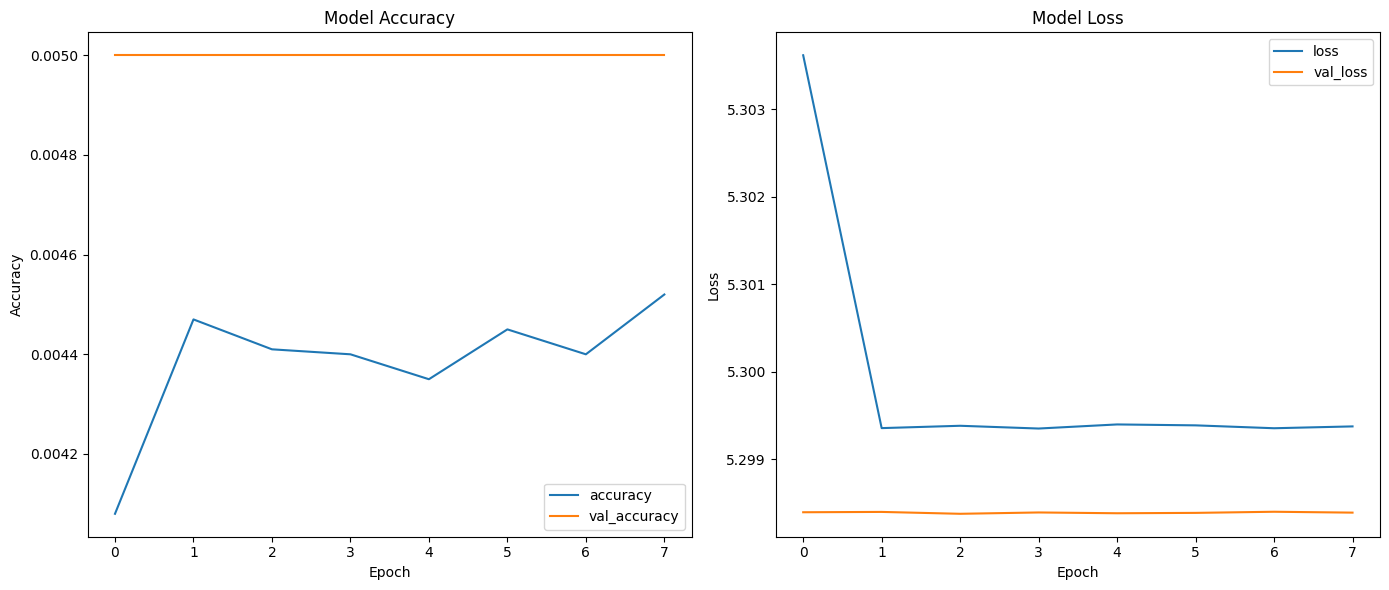

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(val_generator)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")
print("=====================================")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.0051 - loss: 5.2984
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.0047 - loss: 5.2984

Train Loss: 5.298375129699707
Train Accuracy: 0.004999999888241291
-------------------------------------
Validation Loss: 5.298377513885498
Validation Accuracy: 0.004999999888241291


---
### 4차 모델링
- 사전 훈련 층 중 8층만 학습

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 새로운 분류 레이어 추가
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 마지막 8개 층을 학습 가능하게 설정
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 구조 확인
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1,
                    callbacks=[early_stopping])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,866,376 (60.53 MB)

 Trainable params: 14,130,888 (53.91 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 147s 44ms/step - accuracy: 0.1178 - loss: 4.3788 - val_accuracy: 0.3279 - val_loss: 2.8813
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 195s 44ms/step - accuracy: 0.3856 - loss: 2.5974 - val_accuracy: 0.4070 - val_loss: 2.5051
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 0.4786 - loss: 2.1280 - val_accuracy: 0.4370 - val_loss: 2.3441
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 132s 42ms/step - accuracy: 0.5475 - loss: 1.8268 - val_accuracy: 0.4626 - val_loss: 2.2779
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 143s 43ms/step - accuracy: 0.6059 - loss: 1.5680 - val_accuracy: 0.4755 - val_loss: 2.2147
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 133s 43ms/step - accuracy: 0.6540 - loss: 1.3575 - val_accuracy: 0.4841 - val_loss: 2.1793
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 138s 44ms/step - accuracy: 0.7055 - loss: 1.1445 - val_accuracy: 0.4904 - val_loss: 2.2072
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 138s 43ms/step - accuracy: 0.7503 - lo

### 4차 모델링 결과

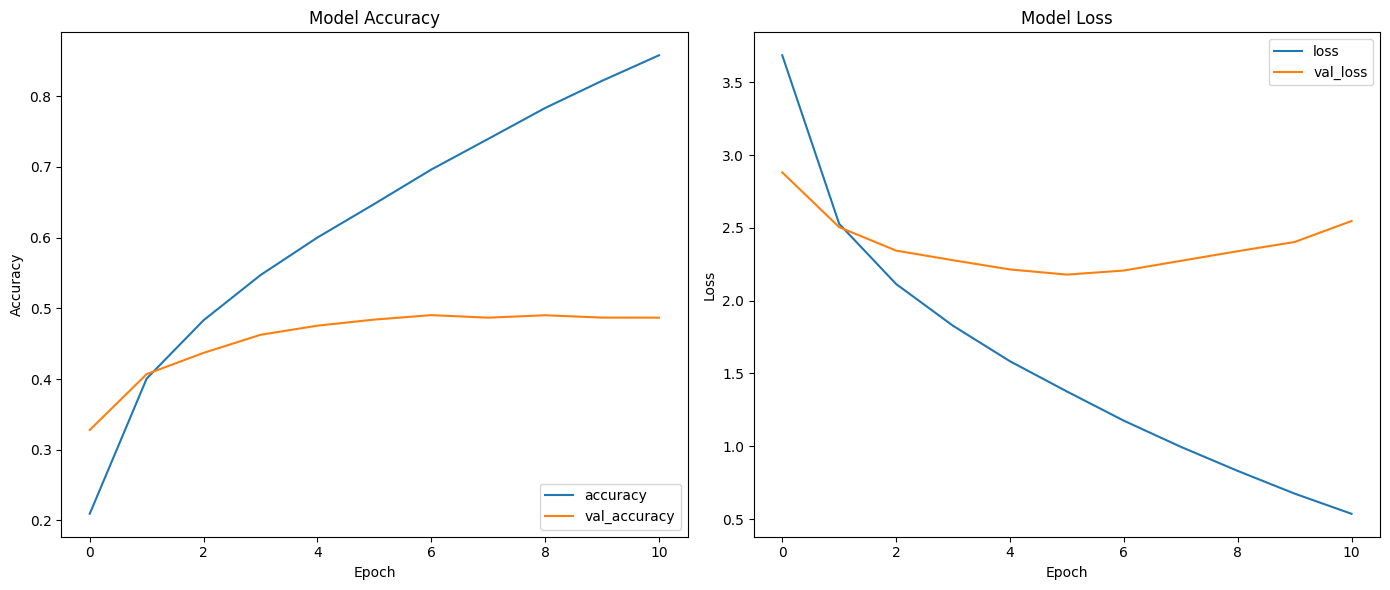

In [7]:
plot_training_history(history)

In [8]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(val_generator)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")
print("=====================================")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.7107 - loss: 1.1577
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4885 - loss: 2.1274

Train Loss: 1.1483491659164429
Train Accuracy: 0.7128099799156189
-------------------------------------
Validation Loss: 2.179314136505127
Validation Accuracy: 0.48410001397132874


---
### 5차 모델링
- 사전 훈련 층 중 12층만 학습
- 모델 학습률 조정


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 새로운 분류 레이어 추가
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 마지막 12개 층을 학습 가능하게 설정
for layer in base_model.layers[:-12]:
    layer.trainable = False
for layer in base_model.layers[-12:]:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 구조 확인
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1,
                    callbacks=[early_stopping])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,866,376 (60.53 MB)

 Trainable params: 15,606,216 (59.53 MB)

 Non-trainable params: 260,160 (1016.25 KB)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 166s 51ms/step - accuracy: 0.0939 - loss: 4.3503 - val_accuracy: 0.3149 - val_loss: 2.8988
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 157s 50ms/step - accuracy: 0.3723 - loss: 2.5634 - val_accuracy: 0.4181 - val_loss: 2.3863
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 202s 50ms/step - accuracy: 0.5082 - loss: 1.9313 - val_accuracy: 0.4587 - val_loss: 2.2480
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 202s 50ms/step - accuracy: 0.6132 - loss: 1.4632 - val_accuracy: 0.4786 - val_loss: 2.1869
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 202s 50ms/step - accuracy: 0.7080 - loss: 1.0645 - val_accuracy: 0.4971 - val_loss: 2.2161
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 156s 50ms/step - accuracy: 0.7851 - loss: 0.7562 - val_accuracy: 0.4899 - val_loss: 2.4219
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 156s 50ms/step - accuracy: 0.8435 - loss: 0.5299 - val_accuracy: 0.4887 - val_loss: 2.6101
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 156s 50ms/step - accuracy: 

### 5차 모델링 결과

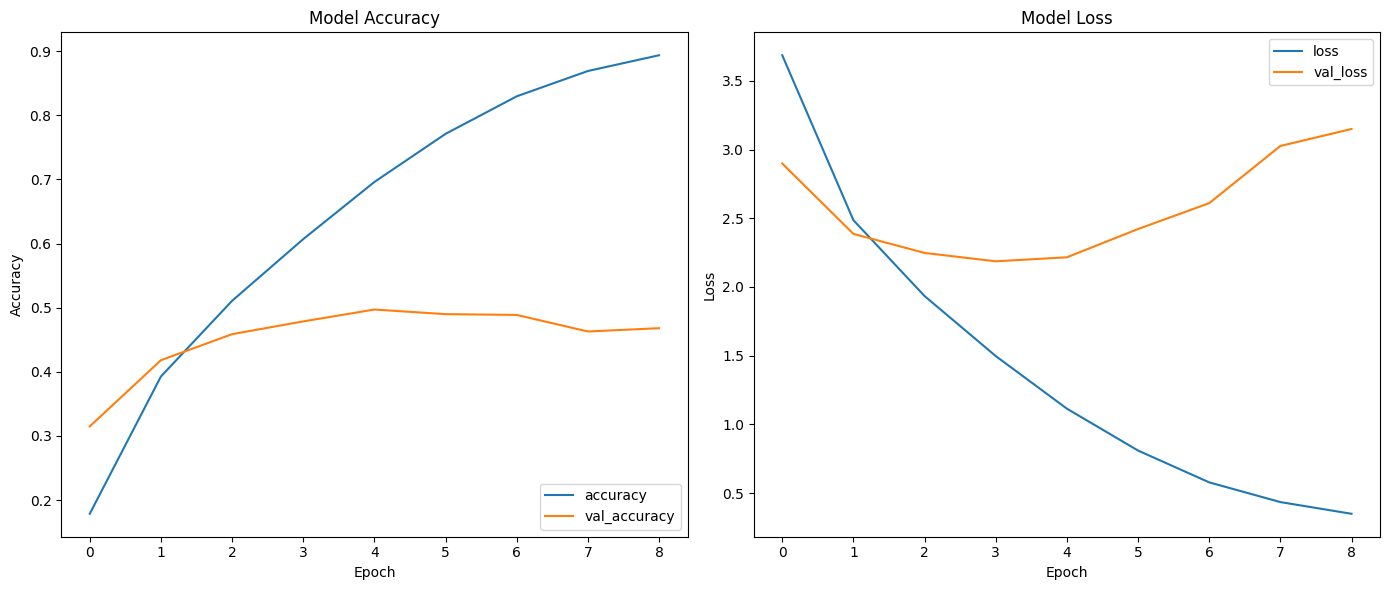

In [10]:
plot_training_history(history)

In [11]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(val_generator)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")
print("=====================================")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 61s 19ms/step - accuracy: 0.7225 - loss: 1.0450
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4840 - loss: 2.1769

Train Loss: 1.0457024574279785
Train Accuracy: 0.7211999893188477
-------------------------------------
Validation Loss: 2.1868808269500732
Validation Accuracy: 0.47859999537467957


---
### 6차 모델링
- 사전 훈련 층 중 4층만 학습

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 새로운 분류 레이어 추가
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 마지막 4개 층을 학습 가능하게 설정
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 구조 확인
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1,
                    callbacks=[early_stopping])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,866,376 (60.53 MB)

 Trainable params: 8,231,112 (31.40 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 103s 32ms/step - accuracy: 0.0933 - loss: 4.5804 - val_accuracy: 0.2761 - val_loss: 3.1935
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 92s 30ms/step - accuracy: 0.3243 - loss: 2.9455 - val_accuracy: 0.3433 - val_loss: 2.8383
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 91s 29ms/step - accuracy: 0.4016 - loss: 2.5442 - val_accuracy: 0.3723 - val_loss: 2.6652
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 92s 29ms/step - accuracy: 0.4595 - loss: 2.2680 - val_accuracy: 0.3959 - val_loss: 2.5687
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 92s 30ms/step - accuracy: 0.4973 - loss: 2.0807 - val_accuracy: 0.4117 - val_loss: 2.4877
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 141s 29ms/step - accuracy: 0.5344 - loss: 1.9097 - val_accuracy: 0.4140 - val_loss: 2.4680
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - accuracy: 0.5673 - loss: 1.7661 - val_accuracy: 0.4195 - val_loss: 2.4481
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - accuracy: 0.60

### 6차 모델링 결과

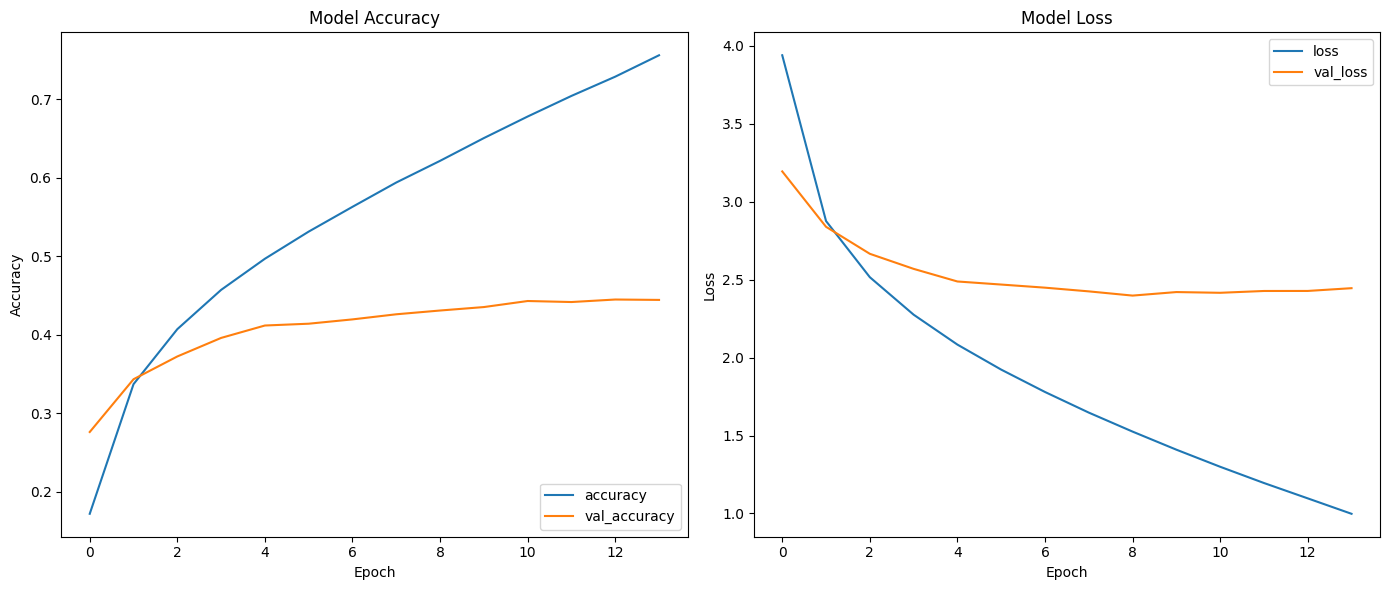

In [13]:
plot_training_history(history)

In [14]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(val_generator)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")
print("=====================================")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - accuracy: 0.6686 - loss: 1.3603
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4311 - loss: 2.3768

Train Loss: 1.3552991151809692
Train Accuracy: 0.6688200235366821
-------------------------------------
Validation Loss: 2.397233247756958
Validation Accuracy: 0.4307999908924103
